In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Load Graphs
If you do not have these two graph files, run the `create_wow_graph.py` python script.

In [3]:
# Load graphs
G = nx.read_gexf('./saved_graphs/G_wow.gexf')
Gcc = nx.read_gexf('./saved_graphs/Gcc_wow.gexf')

# print quick info
print(f'\t\tG\tGcc')
print(f"# of nodes:\t{len(list(G.nodes))}\t{len(list(Gcc.nodes))}")
print(f"# of links:\t{len(list(G.edges))}\t{len(list(Gcc.edges))}")

		G	Gcc
# of nodes:	264	261
# of links:	4006	4005


# Degree Distributions

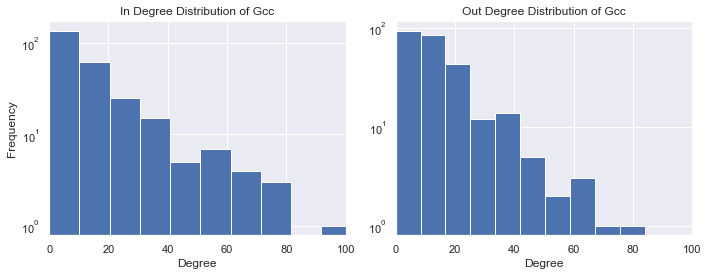

In [4]:
# Get arrays of out- and in-degrees for plotting
out_deg = np.array([v for _, v in Gcc.out_degree])
in_deg = np.array([v for _, v in Gcc.in_degree])

# also get total degrees as it is needed later
tot_deg = np.array([v for _, v in Gcc.degree])

# Create histograms of in and out degree distributions
f, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(in_deg, bins=10)
ax[1].hist(out_deg, bins=10)

ax[0].set_title('In Degree Distribution of Gcc')
ax[1].set_title('Out Degree Distribution of Gcc')

ax[0].set_ylabel('Frequency')
ax[1].set_yticks([])
for i in range(2):
    ax[i].set_xlabel('Degree')
    ax[i].set_yscale('log')
    ax[i].set_xlim([0, 100])
plt.tight_layout()
plt.show()

# Attribute Distributions

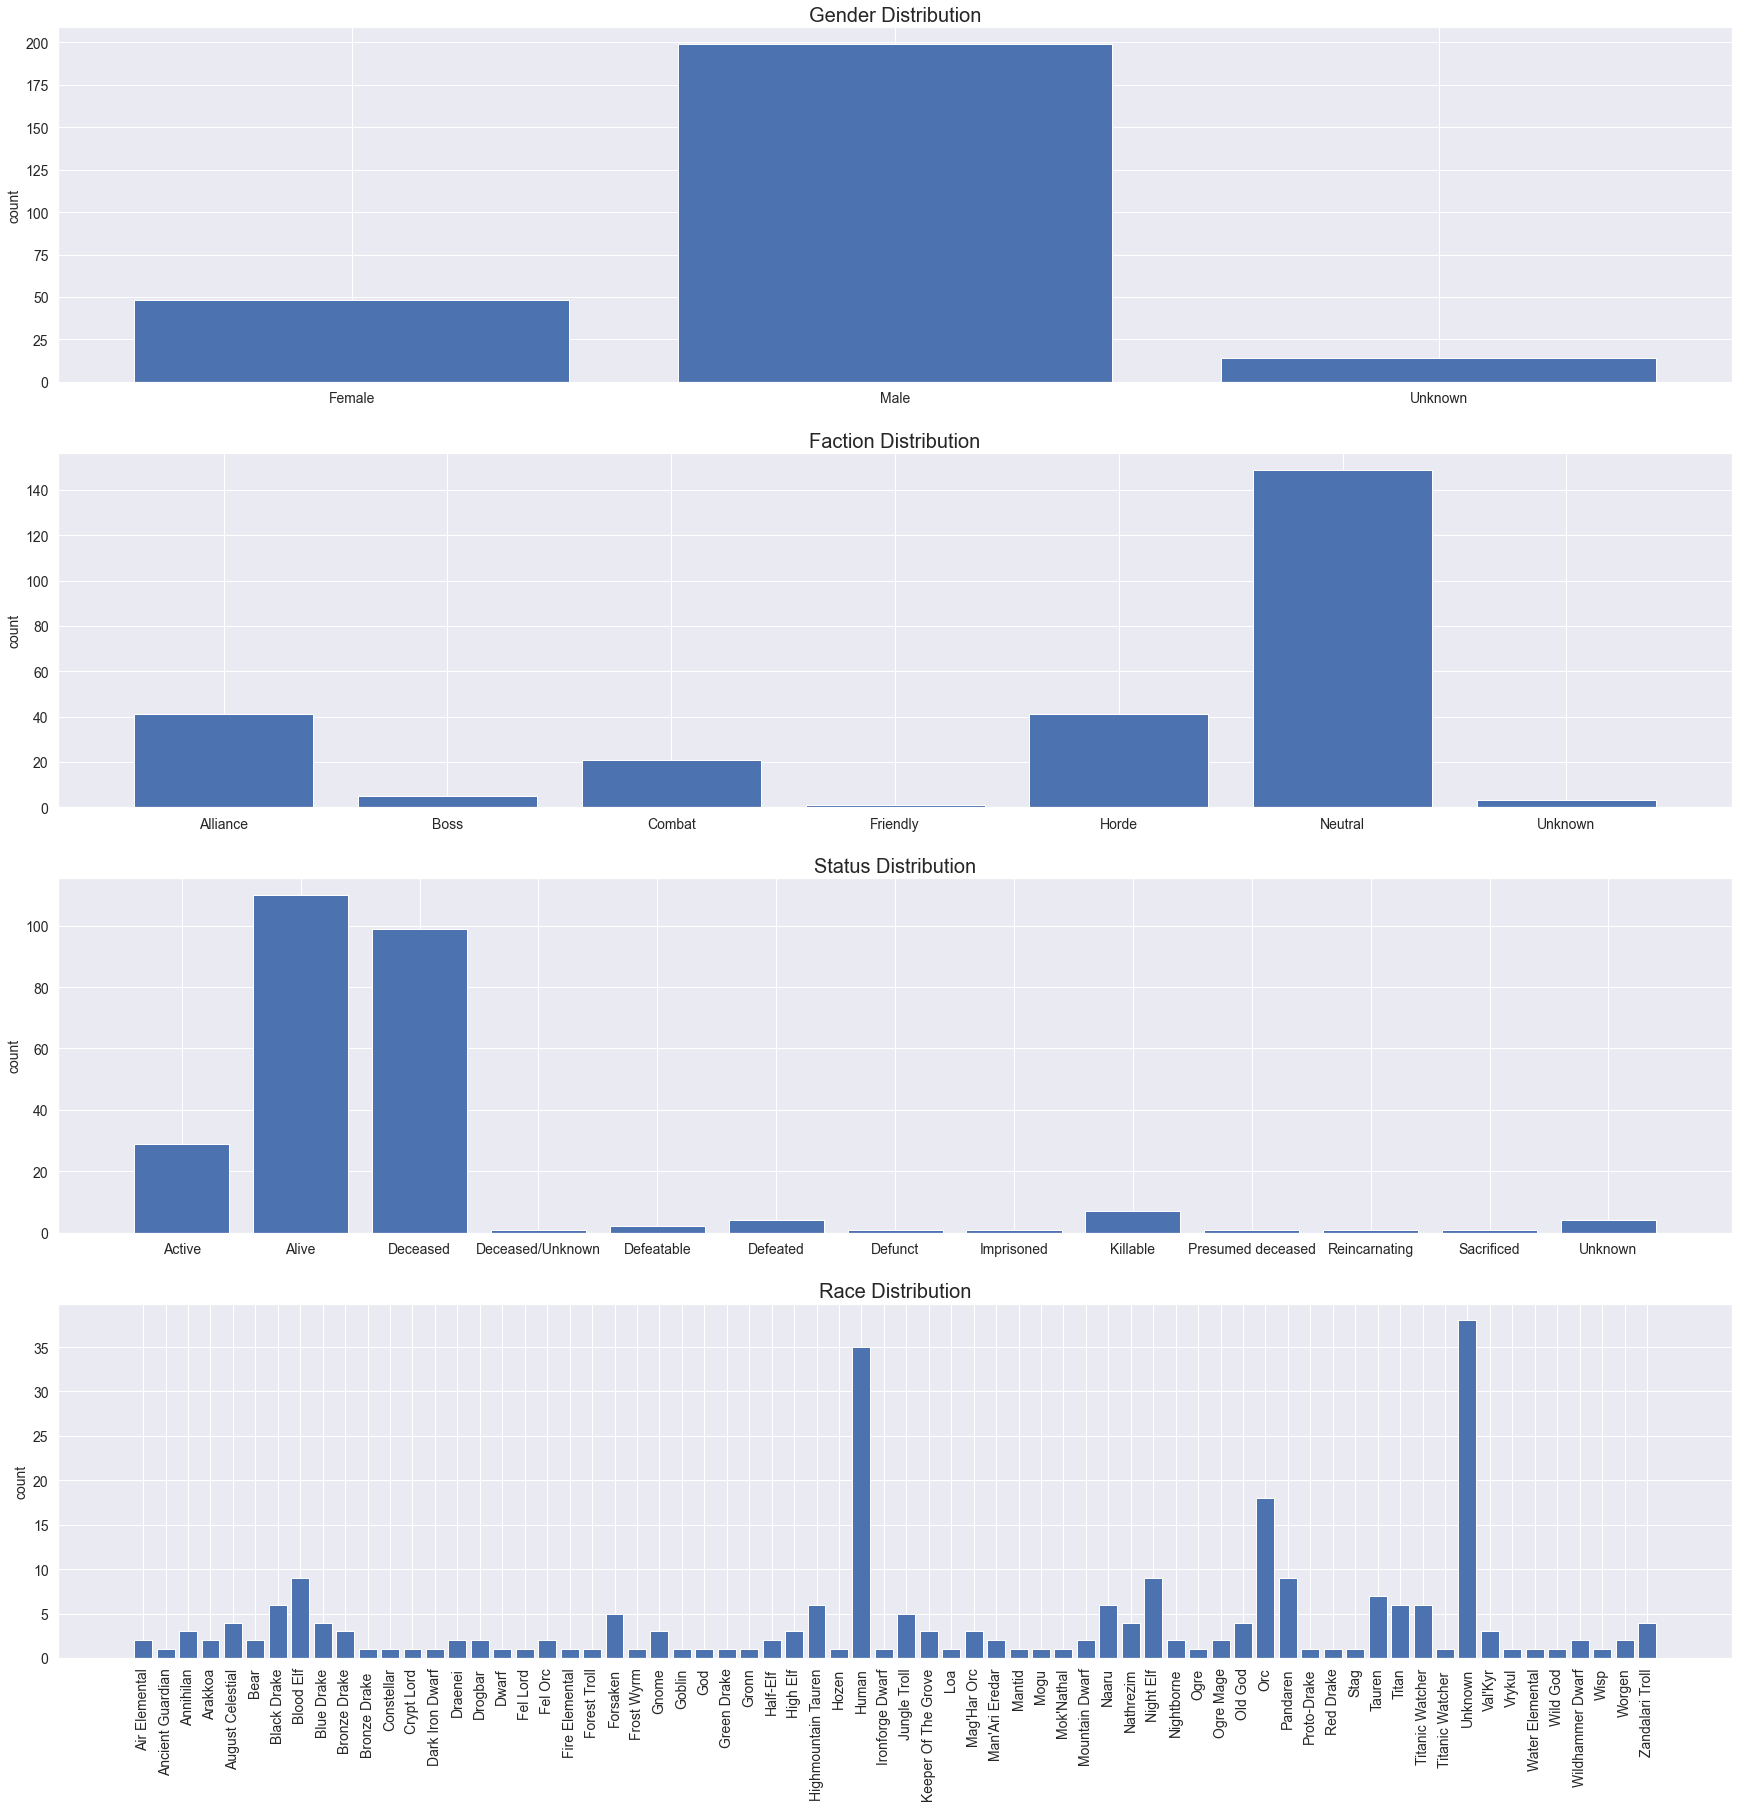

In [5]:
# get distribution of all attributes
attr_names = ['gender', 'faction', 'status', 'race']
f, ax = plt.subplots(len(attr_names), 1, figsize=(30, 30))
for i, aname in enumerate(attr_names):
    attr_list = np.array(list(nx.get_node_attributes(Gcc, aname).values()))
    attr_keys, attr_counts = np.unique(attr_list, return_counts=True)
    ax[i].set_title(f'{aname} distribution'.title(), fontsize=20)
    ax[i].bar(attr_keys, attr_counts)
    ax[i].set_ylabel('count', fontsize=14)

    if aname == 'race':
        xlabel_rotation = 90
    else:
        xlabel_rotation = 0
    plt.setp(ax[i].get_xticklabels(), fontsize=14, rotation=xlabel_rotation)
    plt.setp(ax[i].get_yticklabels(), fontsize=14)
plt.show()